In [66]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [67]:
exp_pref = 'ST260_Day1'
filename = f"../models/MI_measures/{exp_pref}_copulaMI.pkl"
with open(filename,"rb") as f:
    copula = pkl.load(f)

In [68]:
entropies = copula[...,2]

In [69]:
beh = 5
NN = entropies.shape[0]-beh
neurons_dependencies = np.zeros((NN,NN,7)) # H_12, H1_vel+H2_vel/2, min(H1_vel,H2_vel), same for lick

In [70]:
neurons_dependencies[...,2] = entropies[beh:,beh:]
for i in range(NN):
    for j in range(i+1,NN):
        neurons_dependencies[i,j,0] = int(i)
        neurons_dependencies[i,j,1] = int(j)
        neurons_dependencies[i,j,3] = (entropies[beh-1,beh+i]+entropies[beh-1,beh+j])/2
        neurons_dependencies[i,j,4] = min(entropies[beh-1,beh+i],entropies[beh-1,beh+j])
        neurons_dependencies[i,j,5] = (entropies[beh-2,beh+i]+entropies[beh-2,beh+j])/2
        neurons_dependencies[i,j,6] = min(entropies[beh-2,beh+i],entropies[beh-2,beh+j])

(array([1.588e+03, 1.790e+02, 3.700e+01, 1.700e+01, 1.600e+01, 9.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([-3.82061553e-04,  7.36176171e-02,  1.47617296e-01,  2.21616974e-01,
         2.95616653e-01,  3.69616332e-01,  4.43616010e-01,  5.17615689e-01,
         5.91615368e-01,  6.65615046e-01,  7.39614725e-01]),
 <a list of 10 Patch objects>)

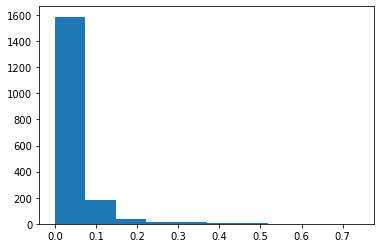

In [71]:
plt.hist(neurons_dependencies[...,2][neurons_dependencies[...,2]!=0])

In [72]:
min_entropy = 0.02
mask = (neurons_dependencies[...,0]>1) & (neurons_dependencies[...,2]>min_entropy) & \
        (neurons_dependencies[...,6]>min_entropy) #& (neurons_dependencies[...,4]<min_entropy)
pairs = neurons_dependencies[mask][...,[0,1]].astype("int")
pairs

array([[ 2, 23],
       [ 2, 49],
       [ 2, 69],
       [ 2, 81],
       [20, 23],
       [23, 49],
       [23, 62],
       [23, 81],
       [49, 62],
       [49, 81],
       [62, 69],
       [62, 81]])

In [73]:
path = '/home/nina/VRData/Processing/pkls'
path_out = '/home/nina/VRData/Processing/mini_pkls'
with open(f"{path}/{exp_pref}_signals.pkl",'rb') as f:
    signal_pkl = pkl.load(f)
with open(f"{path}/{exp_pref}_behaviour.pkl",'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

In [74]:
for pair in pairs:
    mini_exp_pref = f"{exp_pref}_{pair[0]}_{pair[1]}"

    # take the variable with the max H with licks first
    order = np.argsort([-entropies[beh-2,beh+i] for i in pair])

    Y_all = np.concatenate((behaviour_pkl['transformed_licks'].reshape(1,-1),
                            signal_pkl['signals_transformed'][pair[order]])).T
    Y = (Y_all - Y_all.min(axis=0))/(Y_all.max(axis=0)-Y_all.min(axis=0))*0.998+0.001

    data = {}
    data['X'] = (behaviour_pkl['position']%160)/160
    data['Y'] = Y
    data['names'] = np.concatenate((['licks'],pair[order].astype("str")))

    with open(f"{path_out}/{mini_exp_pref}_layer0.pkl",'wb') as f:
        pkl.dump(data,f)

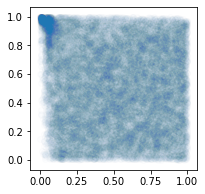

In [75]:
plt.figure(figsize=(3,3))
plt.scatter(*Y[...,[0,1]].T,alpha=0.01)

In [26]:
for pair in pairs:
    for layer in range(2):
        print(f"python train.py {exp_pref}_{pair[0]}_{pair[1]} {layer}")

python train.py ST260_Day3_4_9 0
python train.py ST260_Day3_4_9 1
python train.py ST260_Day3_4_19 0
python train.py ST260_Day3_4_19 1
python train.py ST260_Day3_4_21 0
python train.py ST260_Day3_4_21 1
python train.py ST260_Day3_4_37 0
python train.py ST260_Day3_4_37 1
python train.py ST260_Day3_4_99 0
python train.py ST260_Day3_4_99 1
python train.py ST260_Day3_9_19 0
python train.py ST260_Day3_9_19 1
python train.py ST260_Day3_9_21 0
python train.py ST260_Day3_9_21 1
python train.py ST260_Day3_9_37 0
python train.py ST260_Day3_9_37 1
python train.py ST260_Day3_9_47 0
python train.py ST260_Day3_9_47 1
python train.py ST260_Day3_15_29 0
python train.py ST260_Day3_15_29 1
python train.py ST260_Day3_19_21 0
python train.py ST260_Day3_19_21 1
python train.py ST260_Day3_19_37 0
python train.py ST260_Day3_19_37 1
python train.py ST260_Day3_19_47 0
python train.py ST260_Day3_19_47 1
python train.py ST260_Day3_19_99 0
python train.py ST260_Day3_19_99 1
python train.py ST260_Day3_20_29 0
pytho

In [76]:
import matplotlib.cm as cm
import utils
import torch
import seaborn as sns

path_models = '/home/nina/VRData/Models/mini_pkls'
device = 'cuda:0'

trials = behaviour_pkl['trials'].astype("int")
pos = (behaviour_pkl['position']%160)
cmap = cm.get_cmap('hsv')
colors_T = cmap(trials/trials[-1]/1.2)
interval_ends = [0,60,120,140,160]

def byTrialDensity(ax,data,trials):
    bin = 0.05
    x,y,c = [],[],[]
    for i in range(int(1/bin)):
        for j in range(int(1/bin)):
            mask = (data[:,0]>=i*bin) & (data[:,0]<(i+1)*bin) & \
                    (data[:,1]>=j*bin) & (data[:,1]<(j+1)*bin)
            if len(trials[mask])>5:
                counts = np.bincount(trials[mask])
                x.append((i+1/2)*bin)
                y.append((j+1/2)*bin)
                #c.append(trials[mask].mean()/trials[-1])
                c.append(np.argmax(counts)/trials.max()/1.2)
#                 if (i<2) & (j<2):
#                     print(counts, c[-1])
    ax.scatter(x,y,color=cmap(c),marker="x",s=40,alpha=0.8)
    
def _get_pearson(X, Y):
    from scipy.stats import pearsonr

    X = X.squeeze()
    assert np.isclose(X.max(),1.0,atol=1e-4)
    assert np.isclose(X.min(),0.0,atol=1e-4)
    N = int(160/2.5)
    x = np.linspace(0,1,N)
    p = np.empty(N)

    for b in range(N):
        dat = Y[(X>b*(1./N)) & (X<(b+1)*(1./N))]
        if len(dat)>1:
            p[b] = pearsonr(*dat.T)[0]
        
    p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    

    return np.stack([x[2:-1]*160,p])

In [77]:
pair = pairs[0]
mini_exp_pref = f"{exp_pref}_{pair[0]}_{pair[1]}"
with open(f"{path_out}/{mini_exp_pref}_layer0.pkl",'rb') as f:
    layer0 = pkl.load(f)
with open(f"{path_out}/{mini_exp_pref}_layer1.pkl",'rb') as f:
    layer1 = pkl.load(f)

In [78]:
with open(f"{path_models}/{mini_exp_pref}/models_layer1.pkl",'rb') as f:
    layer1_likelihoods = pkl.load(f)[0]
with open(f"{path_models}/{mini_exp_pref}/layer1/pair_model.pkl",'rb') as f:
    pair_likelihoods = pkl.load(f)

model_layer1 = utils.get_model(f"{path_models}/{mini_exp_pref}/layer1/model_{mini_exp_pref}_1-2.pth",
                               layer1_likelihoods[0],device)
model_pair   = utils.get_model(f"{path_models}/{mini_exp_pref}/layer1/model_{mini_exp_pref}_1-0.pth",
                               pair_likelihoods[0],device)

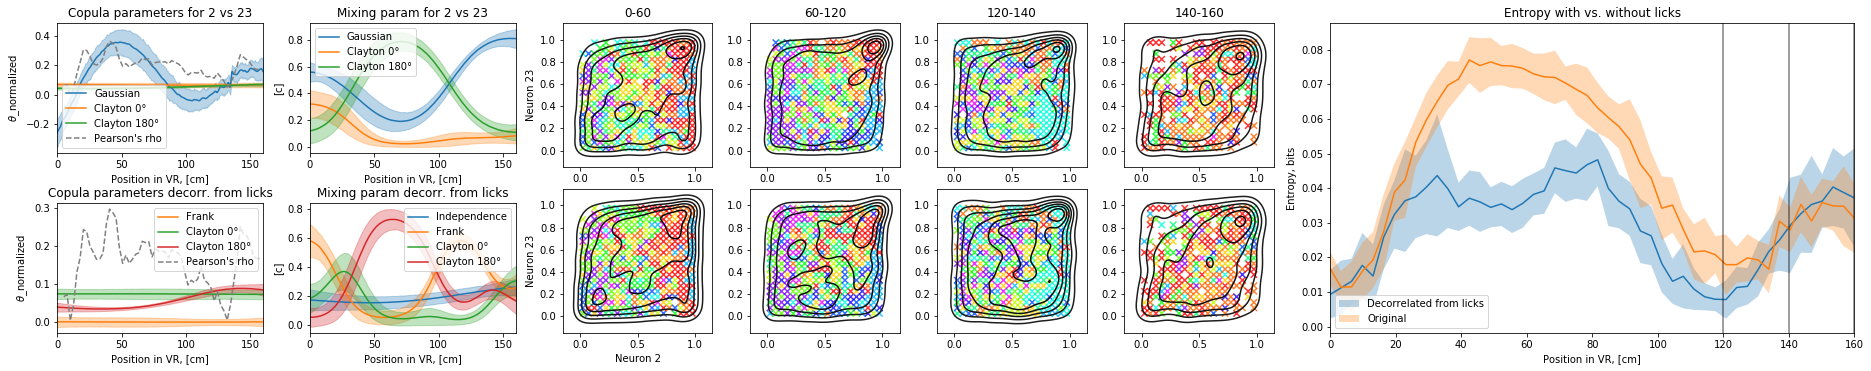

In [79]:
fig = plt.figure(figsize=(26,5))
dens_width = 0.08
plot_width = 0.11
aspect = 5
top_plot_axes = np.array([fig.add_axes([0.04,0.59,plot_width,0.36]),
                    fig.add_axes([0.175,0.59,plot_width,0.36])])
bottom_plot_axes = np.array([fig.add_axes([0.04,0.09,plot_width,0.36]),
                    fig.add_axes([0.175,0.09,plot_width,0.36])])
top_dens_axes = np.array([fig.add_axes([0.31,0.55,dens_width,dens_width*aspect]),
                    fig.add_axes([0.41,0.55,dens_width,dens_width*aspect]),
                    fig.add_axes([0.51,0.55,dens_width,dens_width*aspect]),
                    fig.add_axes([0.61,0.55,dens_width,dens_width*aspect])])
bottom_dens_axes = np.array([fig.add_axes([0.31,0.09,dens_width,dens_width*aspect]),
                    fig.add_axes([0.41,0.09,dens_width,dens_width*aspect]),
                    fig.add_axes([0.51,0.09,dens_width,dens_width*aspect]),
                    fig.add_axes([0.61,0.09,dens_width,dens_width*aspect])])
H_ax = fig.add_axes([0.72,0.09,0.28,0.86])

# define test set (optionally on GPU)
testX = np.linspace(0,1,1000)
test_x = torch.tensor(testX).float().to(device=device)

utils.Plot_MixModel_Param_MCMC(top_plot_axes,
                         model_pair,test_x,testX*160,
                         rho=_get_pearson(pos/160,layer0['Y'][:,[1,2]]),
                         title='for {} vs {}'.format(*layer0['names'][1:]))
utils.Plot_MixModel_Param_MCMC(bottom_plot_axes,
                         model_layer1,test_x,testX*160,
                         rho=_get_pearson(pos/160,layer1['Y'][:,[0,1]]),
                         title='decorr. from licks')

def plot(Y,ax,mask,name):
    mrg = 0.15
    byTrialDensity(ax,Y[mask],trials[mask]//10)
    sns.kdeplot(*Y[(pos>=s) & (pos<e)].T, ax=ax, 
                shade=False,  shade_lowest=False, 
                alpha=1.0, color='black', n_levels=6)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))
titles = ["{}-{}".format(s,e) for s,e in zip(interval_ends[:-1],interval_ends[1:])]
for s,e,axT,axB,name in zip(interval_ends[:-1],interval_ends[1:],
                            top_dens_axes.flatten(),bottom_dens_axes.flatten(),titles):
    mask = (pos>=s) & (pos<e)
    plot(layer0['Y'][:,[1,2]],axT,mask,name)
    plot(layer1['Y'][:,[0,1]],axB,mask,'')
top_dens_axes[0].set_ylabel(f"Neuron {layer0['names'][2]}")
bottom_dens_axes[0].set_ylabel(f"Neuron {layer0['names'][2]}")
bottom_dens_axes[0].set_xlabel(f"Neuron {layer0['names'][1]}")
    
# now calculate and plot the entorpy
x = torch.linspace(0,1,50,device=device)
x_cpu = x.cpu().numpy()*160
(MI, MI_mean, MI_std) = model_layer1.MI(x, f_size=20)
H_ax.plot(x_cpu,-MI_mean.cpu().numpy())
H_ax.fill_between(x_cpu,-(MI_mean-MI_std).cpu().numpy(),-(MI_mean+MI_std).cpu().numpy(),alpha=0.3,label='Decorrelated from licks')
(MI, MI_mean, MI_std) = model_pair.MI(x, f_size=20)
H_ax.plot(x_cpu,-MI_mean.cpu().numpy())
H_ax.fill_between(x_cpu,-(MI_mean-MI_std).cpu().numpy(),-(MI_mean+MI_std).cpu().numpy(),alpha=0.3,label='Original')
H_ax.axvline(120, color='black', alpha=0.5)
H_ax.axvline(140, color='black', alpha=0.5)
H_ax.axvline(160, color='black', alpha=0.5)
H_ax.set(title='Entropy with vs. without licks', xlim=(0,160), xlabel='Position in VR, [cm]', ylabel='Entropy, bits')
H_ax.legend()
# fig.savefig(f"{path_models}/plot_{mini_exp_pref}.png")
# fig.savefig(f"{path_models}/plot_{mini_exp_pref}.svg")

2-23 done
2-49 done
2-69 done
2-81 done
20-23 done
49-23 done
62-23 done
81-23 done
62-49 done
49-81 done
62-69 done
62-81 done


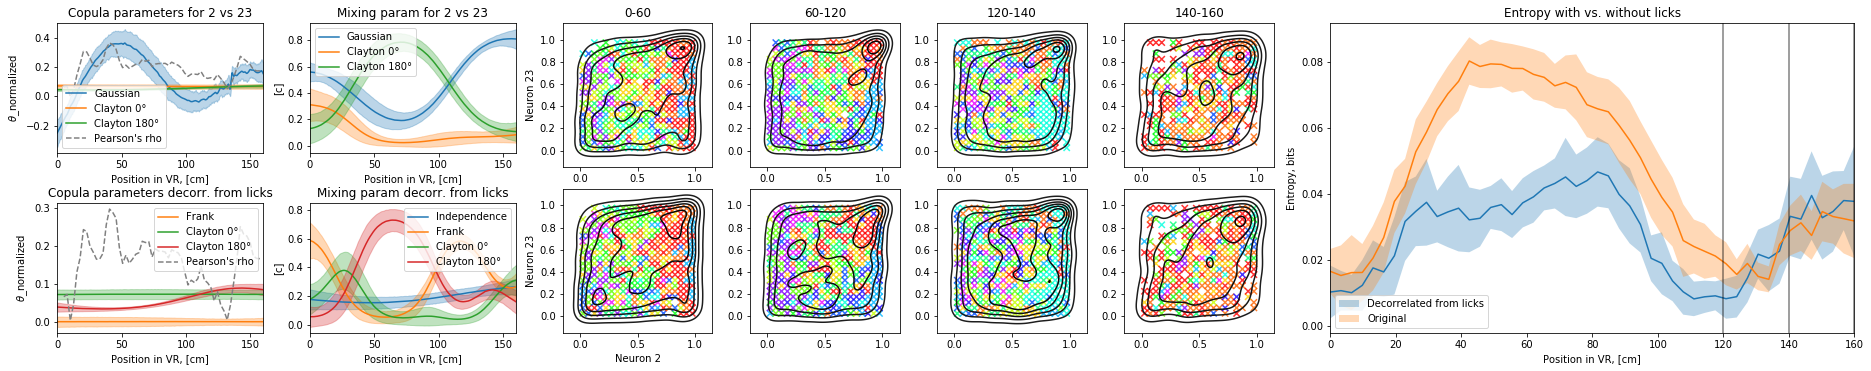

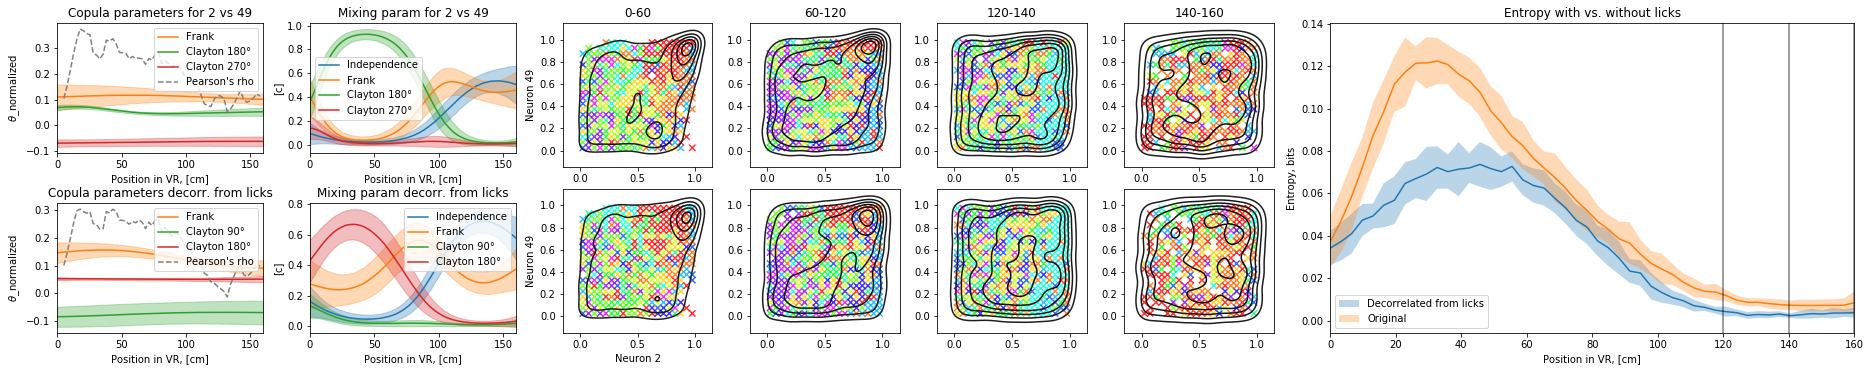

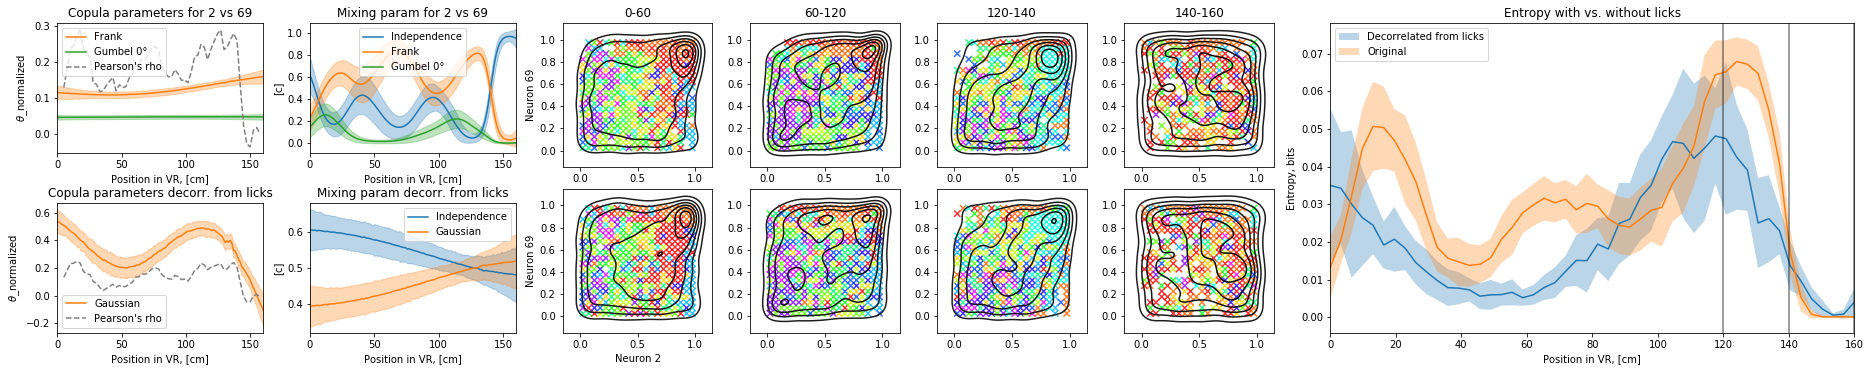

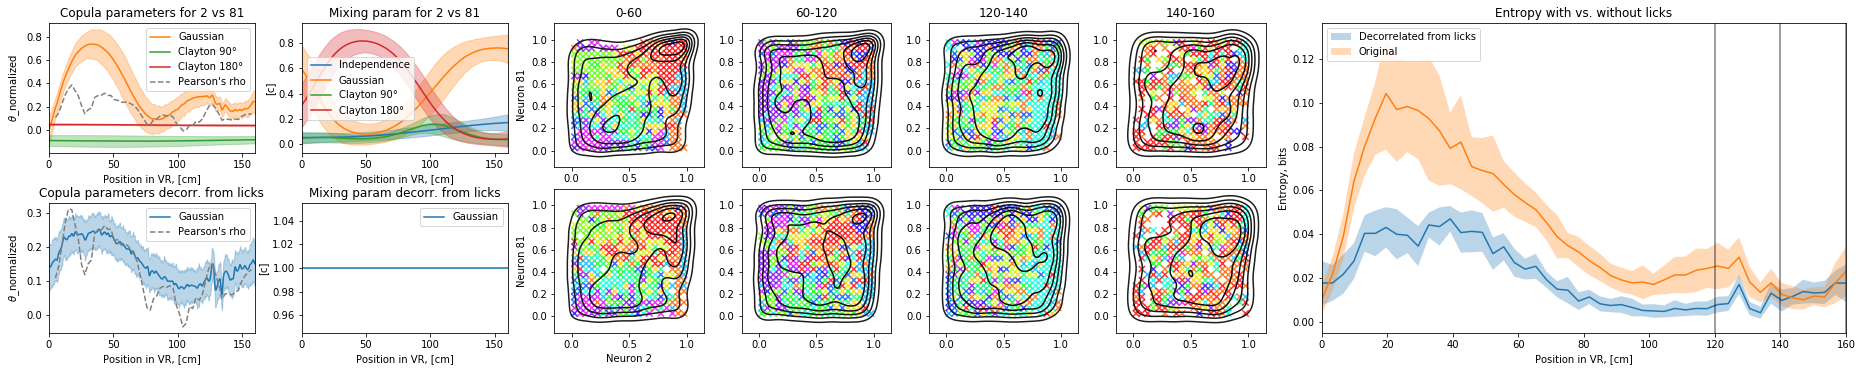

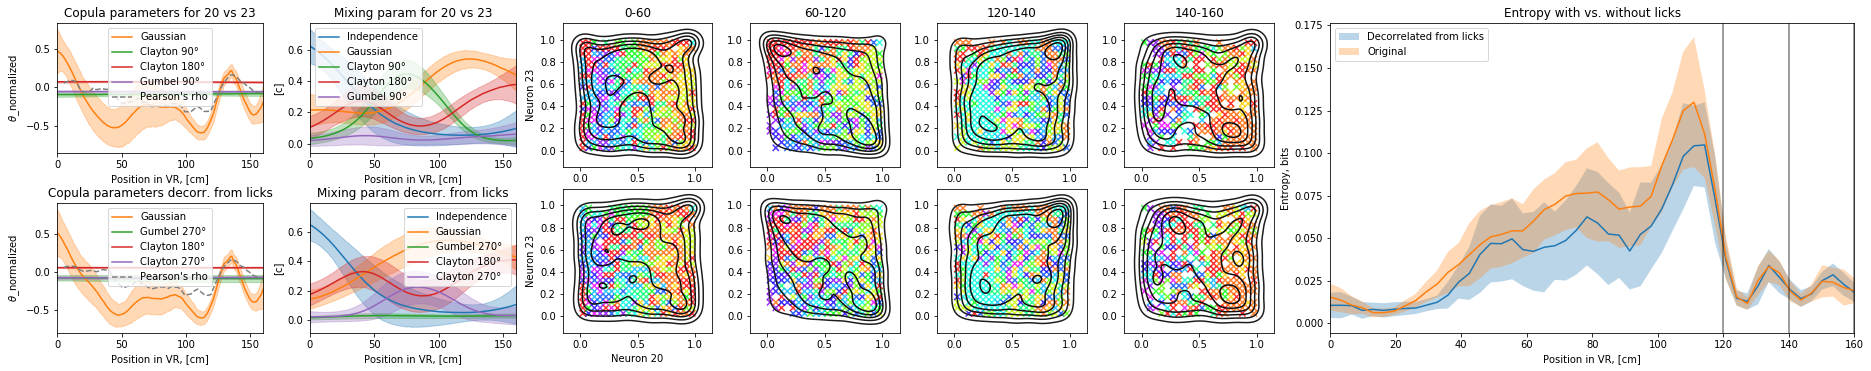

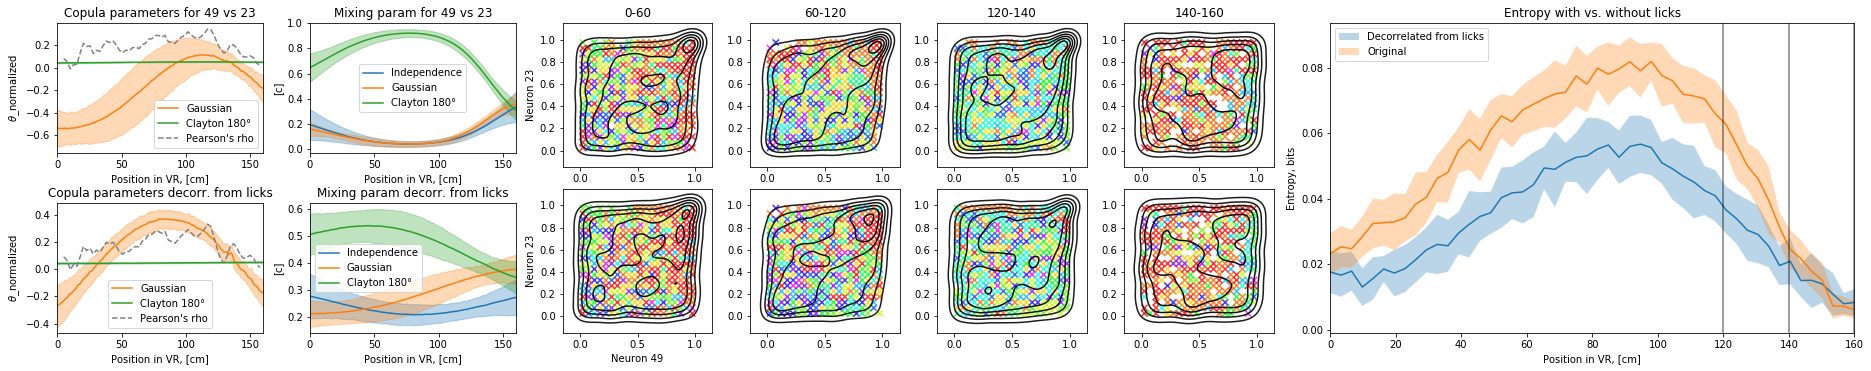

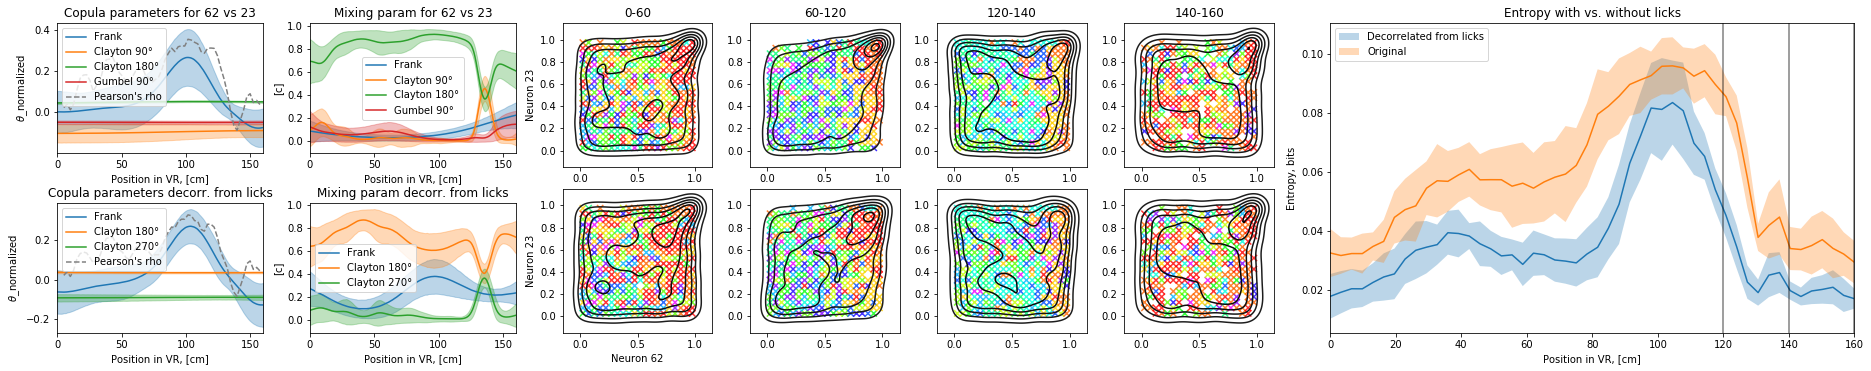

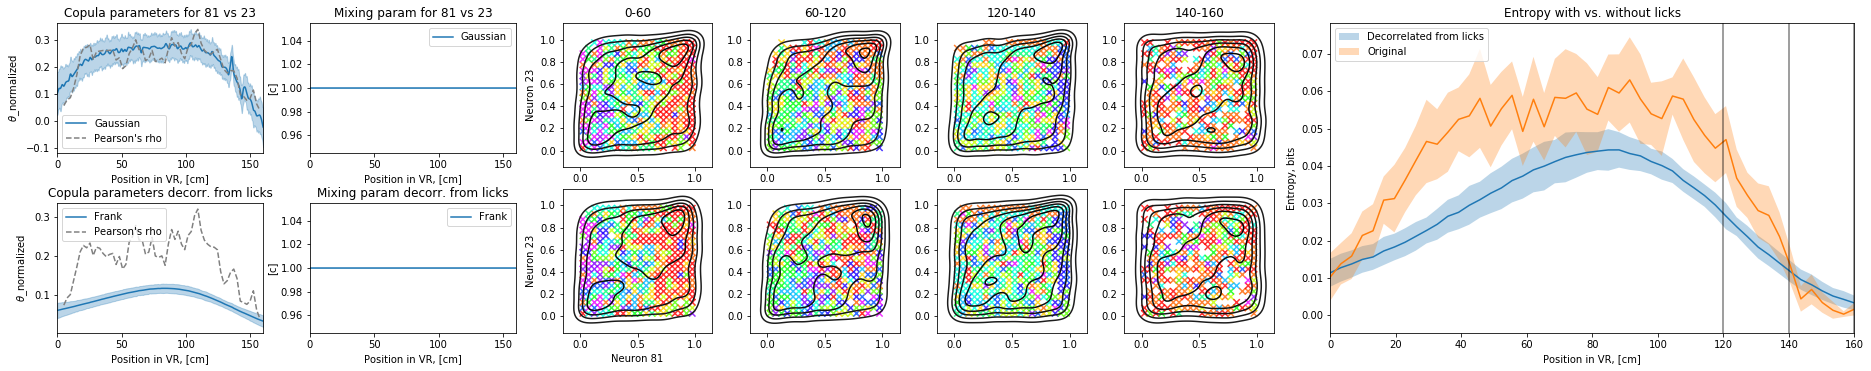

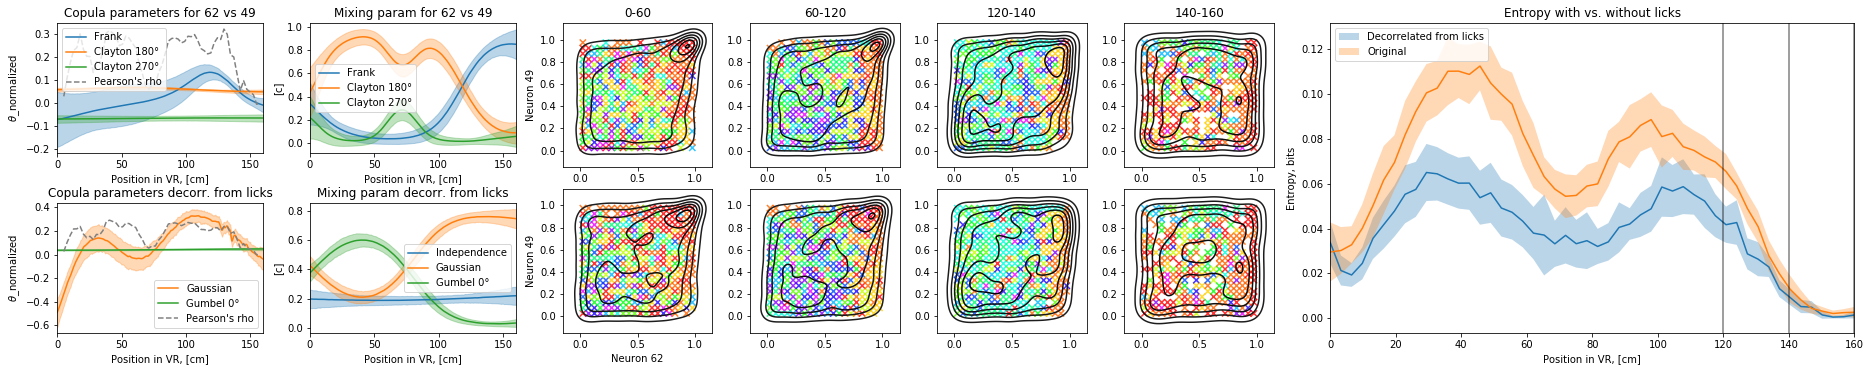

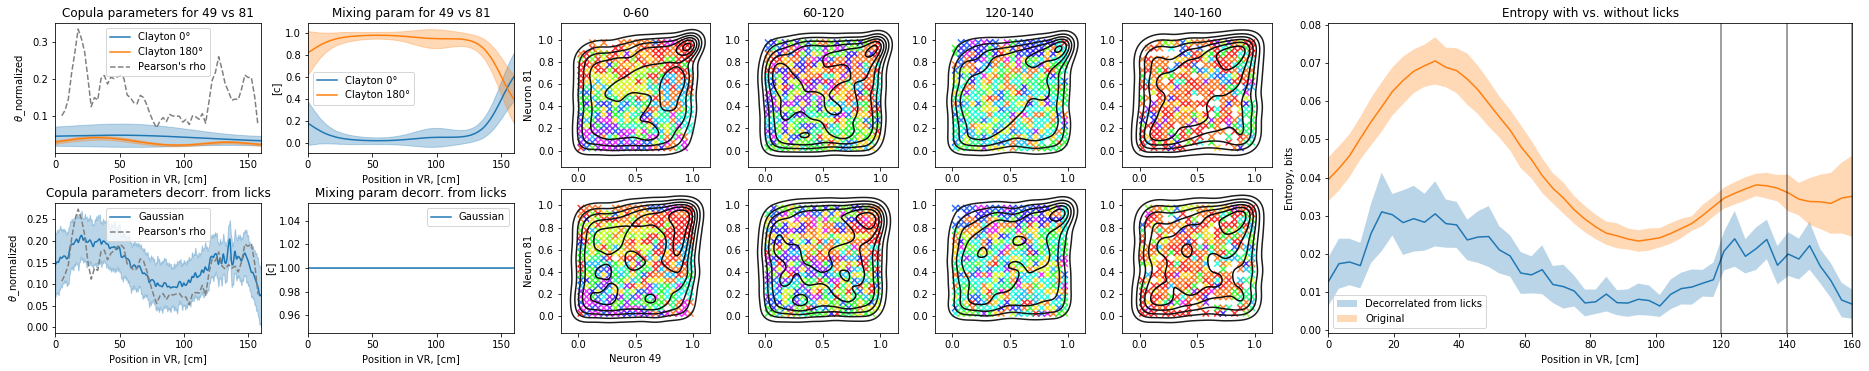

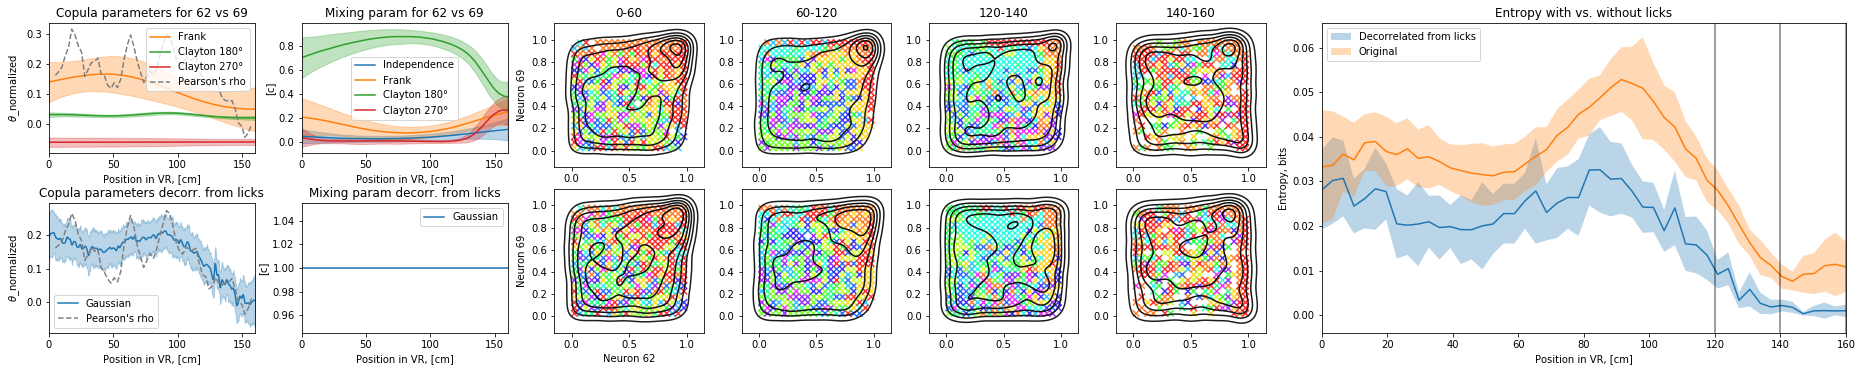

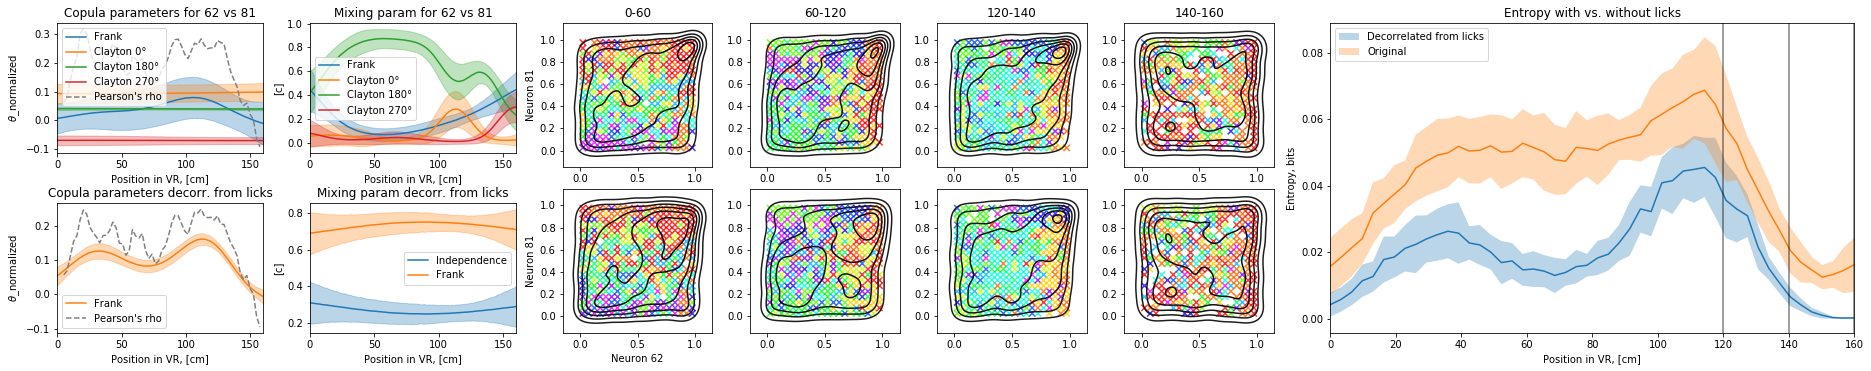

In [80]:
for pair in pairs:
    mini_exp_pref = f"{exp_pref}_{pair[0]}_{pair[1]}"
    with open(f"{path_out}/{mini_exp_pref}_layer0.pkl",'rb') as f:
        layer0 = pkl.load(f)
    with open(f"{path_out}/{mini_exp_pref}_layer1.pkl",'rb') as f:
        layer1 = pkl.load(f)
    with open(f"{path_models}/{mini_exp_pref}/models_layer1.pkl",'rb') as f:
        layer1_likelihoods = pkl.load(f)[0]
    with open(f"{path_models}/{mini_exp_pref}/layer1/pair_model.pkl",'rb') as f:
        pair_likelihoods = pkl.load(f)

    model_layer1 = utils.get_model(f"{path_models}/{mini_exp_pref}/layer1/model_{mini_exp_pref}_1-2.pth",
                                   layer1_likelihoods[0],device)
    model_pair   = utils.get_model(f"{path_models}/{mini_exp_pref}/layer1/model_{mini_exp_pref}_1-0.pth",
                                   pair_likelihoods[0],device)
    
    fig = plt.figure(figsize=(26,5))
    dens_width = 0.08
    plot_width = 0.11
    aspect = 5
    top_plot_axes = np.array([fig.add_axes([0.04,0.59,plot_width,0.36]),
                        fig.add_axes([0.175,0.59,plot_width,0.36])])
    bottom_plot_axes = np.array([fig.add_axes([0.04,0.09,plot_width,0.36]),
                        fig.add_axes([0.175,0.09,plot_width,0.36])])
    top_dens_axes = np.array([fig.add_axes([0.31,0.55,dens_width,dens_width*aspect]),
                        fig.add_axes([0.41,0.55,dens_width,dens_width*aspect]),
                        fig.add_axes([0.51,0.55,dens_width,dens_width*aspect]),
                        fig.add_axes([0.61,0.55,dens_width,dens_width*aspect])])
    bottom_dens_axes = np.array([fig.add_axes([0.31,0.09,dens_width,dens_width*aspect]),
                        fig.add_axes([0.41,0.09,dens_width,dens_width*aspect]),
                        fig.add_axes([0.51,0.09,dens_width,dens_width*aspect]),
                        fig.add_axes([0.61,0.09,dens_width,dens_width*aspect])])
    H_ax = fig.add_axes([0.72,0.09,0.28,0.86])

    # define test set (optionally on GPU)
    testX = np.linspace(0,1,1000)
    test_x = torch.tensor(testX).float().to(device=device)

    utils.Plot_MixModel_Param_MCMC(top_plot_axes,
                             model_pair,test_x,testX*160,
                             rho=_get_pearson(pos/160,layer0['Y'][:,[1,2]]),
                             title='for {} vs {}'.format(*layer0['names'][1:]))
    utils.Plot_MixModel_Param_MCMC(bottom_plot_axes,
                             model_layer1,test_x,testX*160,
                             rho=_get_pearson(pos/160,layer1['Y'][:,[0,1]]),
                             title='decorr. from licks')

    def plot(Y,ax,mask,name):
        mrg = 0.15
        byTrialDensity(ax,Y[mask],trials[mask]//10)
        sns.kdeplot(*Y[(pos>=s) & (pos<e)].T, ax=ax, 
                    shade=False,  shade_lowest=False, 
                    alpha=1.0, color='black', n_levels=6)
        ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))
    titles = ["{}-{}".format(s,e) for s,e in zip(interval_ends[:-1],interval_ends[1:])]
    for s,e,axT,axB,name in zip(interval_ends[:-1],interval_ends[1:],
                                top_dens_axes.flatten(),bottom_dens_axes.flatten(),titles):
        mask = (pos>=s) & (pos<e)
        plot(layer0['Y'][:,[1,2]],axT,mask,name)
        plot(layer1['Y'][:,[0,1]],axB,mask,'')
    top_dens_axes[0].set_ylabel(f"Neuron {layer0['names'][2]}")
    bottom_dens_axes[0].set_ylabel(f"Neuron {layer0['names'][2]}")
    bottom_dens_axes[0].set_xlabel(f"Neuron {layer0['names'][1]}")

    # now calculate and plot the entorpy
    x = torch.linspace(0,1,50,device=device)
    x_cpu = x.cpu().numpy()*160
    (MI, MI_mean, MI_std) = model_layer1.MI(x, f_size=20)
    H_ax.plot(x_cpu,-MI_mean.cpu().numpy())
    H_ax.fill_between(x_cpu,-(MI_mean-MI_std).cpu().numpy(),-(MI_mean+MI_std).cpu().numpy(),alpha=0.3,label='Decorrelated from licks')
    (MI, MI_mean, MI_std) = model_pair.MI(x, f_size=20)
    H_ax.plot(x_cpu,-MI_mean.cpu().numpy())
    H_ax.fill_between(x_cpu,-(MI_mean-MI_std).cpu().numpy(),-(MI_mean+MI_std).cpu().numpy(),alpha=0.3,label='Original')
    H_ax.axvline(120, color='black', alpha=0.5)
    H_ax.axvline(140, color='black', alpha=0.5)
    H_ax.axvline(160, color='black', alpha=0.5)
    H_ax.set(title='Entropy with vs. without licks', xlim=(0,160), xlabel='Position in VR, [cm]', ylabel='Entropy, bits')
    H_ax.legend()
    fig.savefig(f"{path_models}/plot_{mini_exp_pref}.png")
    fig.savefig(f"{path_models}/plot_{mini_exp_pref}.svg")
    print(f"{layer0['names'][1]}-{layer0['names'][2]} done")